In [1]:
import os
import time
import shutil
import random
import pickle
import datetime
import itertools
import random as rn
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [2]:
test_df = pd.read_csv('Data/test.csv', dtype='string')
test_predictions = pd.read_csv('test_predictions.csv', dtype='string')

In [3]:
test_df.head()

,path,label
0,Data/test/378_kt_42945.jpg,KT
1,Data/test/29_quay_61764.jpg,QUAY
2,Data/test/2_remittances_64530.jpg,REMITTANCES
3,Data/test/414_plentifully_58240.jpg,PLENTIFULLY
4,Data/test/418_Cuneiform_18632.jpg,CUNEIFORM


In [4]:
test_predictions.head()

,original,predicted
0,KT,BISEE
1,QUAY,QUAY
2,REMITTANCES,REMITTANCES
3,PLENTIFULLY,PLENTIFULLY
4,CUNEIFORM,CUNEIFORM


## Performance Analysis
<br>

### Word Accuracy
<br>

In [5]:
accurate_predictions = (test_predictions.original == test_predictions.predicted).sum()
word_accuracy = accurate_predictions/len(test_df)
print("\nTotal Words : {}".format(len(test_df)))
print("\nCorrect Predictions : {}".format(accurate_predictions))
print("\nWord Accuracy : {}\n".format(np.round(word_accuracy*100,1)))


Total Words : 80000

Correct Predictions : 62547

Word Accuracy : 78.2



### Letter Accuracy
<br>

In [6]:
mismatch_count = []

for idx, row in enumerate(test_predictions.values):

    original = str(row[0])
    predicted = str(row[1])
    num_mismatch = 0

    for i in range(min(len(original), len(predicted))):

        if(original[i]!=predicted[i]):
            num_mismatch+=1

    num_mismatch+=abs(len(predicted)-len(original)) # Considering the extra length of the predicted label also as mismatch

    mismatch_count.append(num_mismatch)


In [7]:
test_predictions['mismatch_count'] = mismatch_count

In [8]:
test_predictions.head()

,original,predicted,mismatch_count
0,KT,BISEE,5
1,QUAY,QUAY,0
2,REMITTANCES,REMITTANCES,0
3,PLENTIFULLY,PLENTIFULLY,0
4,CUNEIFORM,CUNEIFORM,0


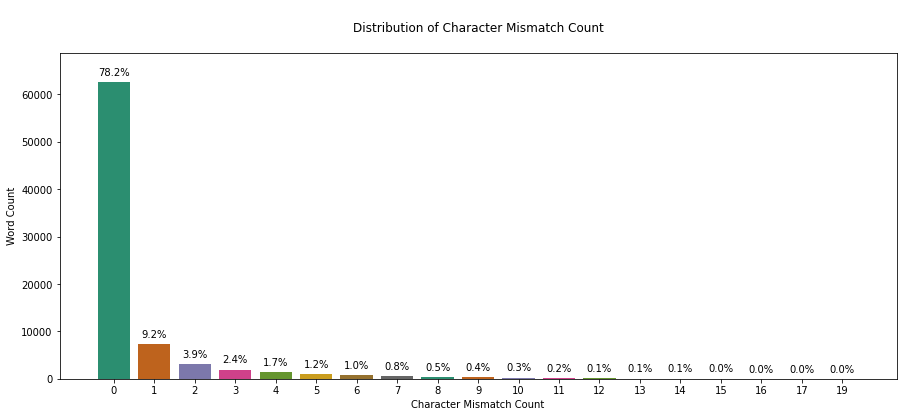

In [9]:
plt.figure(figsize=(15,6))
ax = sns.countplot(x='mismatch_count', data=test_predictions, palette='Dark2')

plt.title("\nDistribution of Character Mismatch Count\n")
plt.xlabel("Character Mismatch Count")
plt.ylabel("Word Count")

plt.margins(0.05, 0.1)

for p in ax.patches:
  x=p.get_bbox().get_points()[:,0]
  y=p.get_bbox().get_points()[1,1]
  ax.annotate('{:.1f}%'.format(100.*y/len(test_predictions)), (x.mean(), y+1000), 
          ha='center', va='bottom') 

plt.show()

In [10]:
mismatch_percentage = []

for idx, row in enumerate(test_predictions.values):

    original = str(row[0])
    predicted = str(row[1])
    num_mismatch = 0

    for i in range(min(len(original), len(predicted))):
        if(original[i]!=predicted[i]):
            num_mismatch+=1
    
    num_mismatch+=abs(len(original)-len(predicted))
            
    percentage = int(np.round((num_mismatch/len(original))*100))
    
    mismatch_percentage.append(percentage)

In [11]:
test_predictions['mismatch_percentage'] = mismatch_percentage

In [12]:
test_predictions.head() 

,original,predicted,mismatch_count,mismatch_percentage
0,KT,BISEE,5,250
1,QUAY,QUAY,0,0
2,REMITTANCES,REMITTANCES,0,0
3,PLENTIFULLY,PLENTIFULLY,0,0
4,CUNEIFORM,CUNEIFORM,0,0


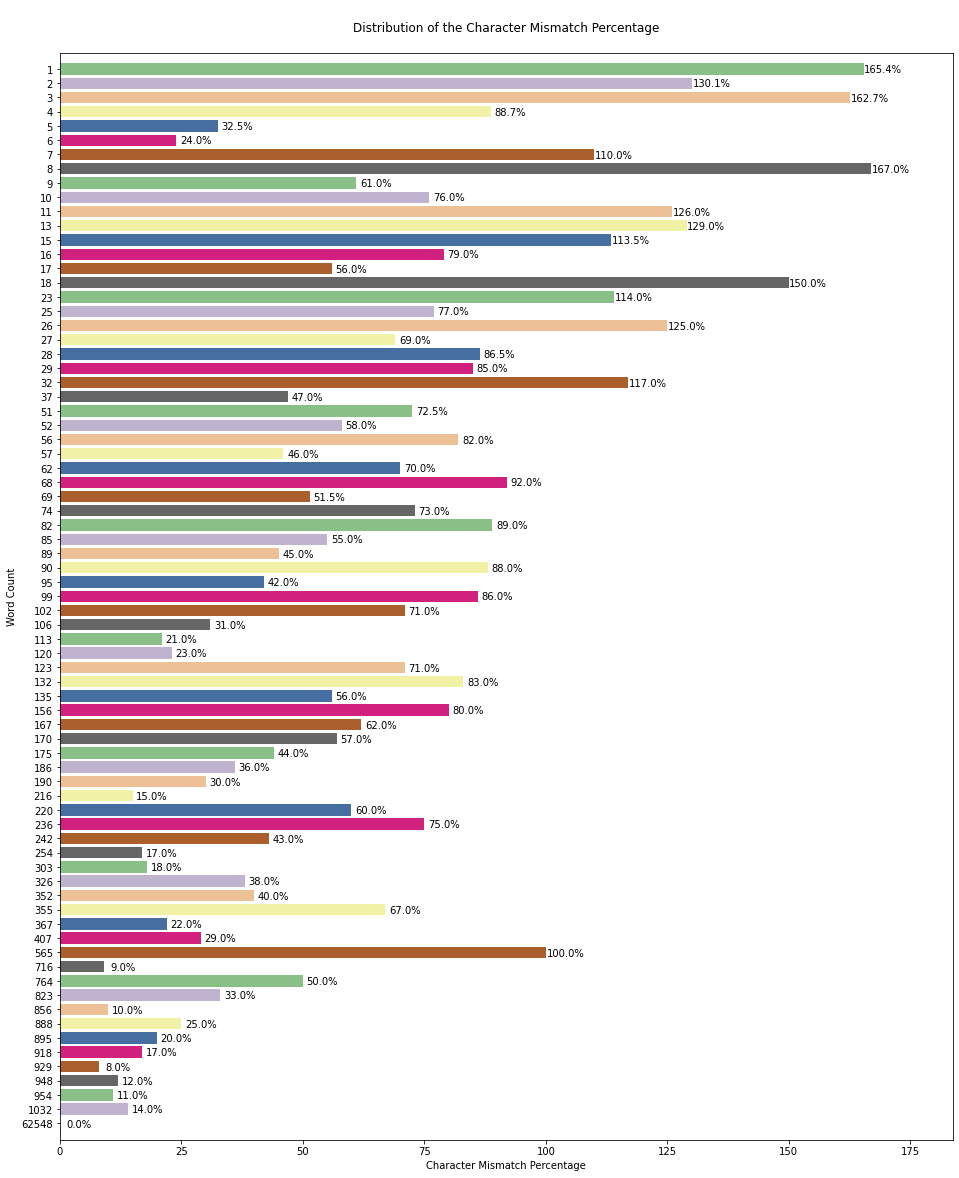

In [13]:
plt.figure(figsize=(16,20))
ax = sns.barplot(x=test_predictions['mismatch_percentage'].value_counts().index, y=test_predictions['mismatch_percentage'].value_counts().values, ci=False, palette='Accent', orient = 'h')

plt.title("\nDistribution of the Character Mismatch Percentage\n")
plt.xlabel("Character Mismatch Percentage")
plt.ylabel("Word Count")

plt.margins(0.1, 0.01)

for p in ax.patches:
    width = p.get_width()
    plt.text(4+p.get_width(), p.get_y()+0.55*p.get_height(),
            '{:1.1f}%'.format(width),
            ha='center', va='center')

plt.show()

### Percentage > 100 signifies len(predicted)>len(original)

## Error Analysis
<br>

We will be categorizing the predictions based on the percentage of mismatch characters as follows,

- Character Mismatch Percentage <= 15% --- __BEST CASE__


- 15% < Character Mismatch Percentage <= 40% --- __AVERAGE CASE__


- 40% < Character Mismatch Percentage --- __WORST CASE__
<br><br>

In [14]:
test_predictions['case']=[""]*len(test_predictions) # Adding the case column

In [15]:
def view_images(indices, case):
    
    paths = test_df.path.values[indices]
    labels = test_df.label.values[indices]
    predictions = test_predictions.predicted.values[indices]
    
    fig = plt.figure(figsize=(15, 15))
    plt.suptitle('\n{} Images'.format(case), y=0.95)
    for i in range(10):
    
        ax = fig.add_subplot(5, 2, i+1, xticks=[], yticks=[])
        
        img_string = tf.io.read_file(paths[i])
        img = tf.image.decode_image(img_string, channels=1, dtype=tf.dtypes.float32, expand_animations=False)
        img = tf.image.resize(img, [64, 256])
        img = tf.image.grayscale_to_rgb(img)
        
        original = labels[i]
        predicted = predictions[i]
        
        ax.imshow(img)
        ax.set_title(f"Original: {original}      Predicted: {predicted}")

### Sample Images in the BEST CASE Set
<br>

In [16]:
test_predictions['case'] = ["best" if p <= 15 else test_predictions['case'][idx] for idx, p in enumerate(test_predictions['mismatch_percentage'].values)]

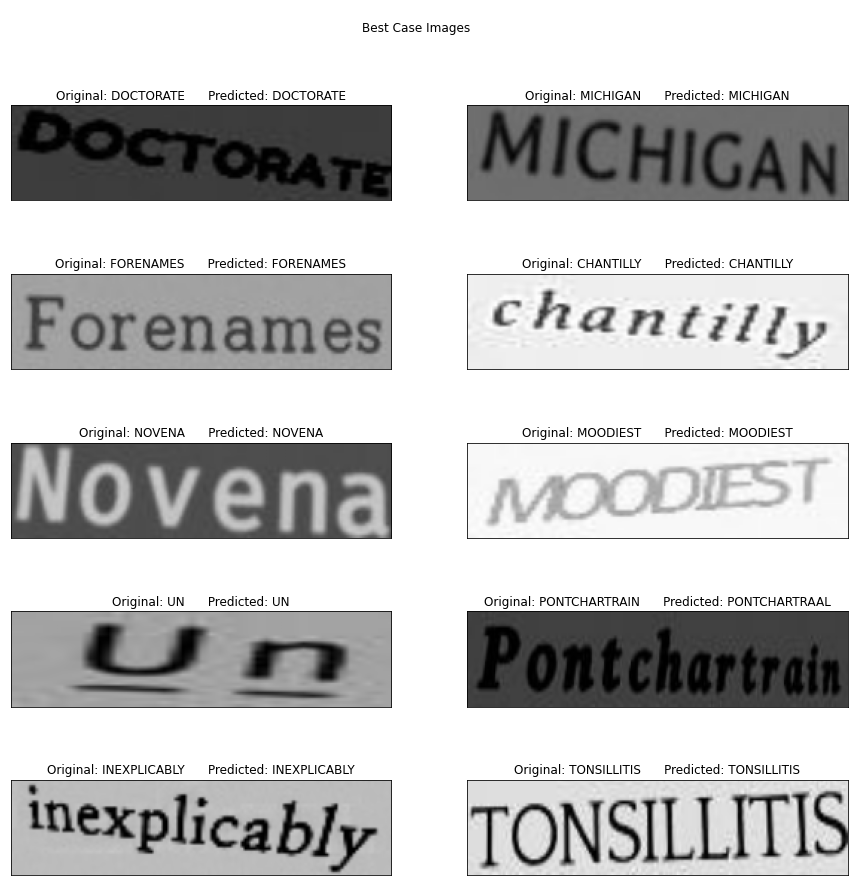

In [17]:
best_case_images = test_df[test_predictions['case']=='best']['path'].index.values
random.shuffle(best_case_images)
view_images(best_case_images, 'Best Case')

### Sample Images in the AVERAGE CASE Set
<br>

In [18]:
test_predictions['case'] = ["average" if (p > 15) and (p <= 40) else test_predictions['case'][idx] for idx, p in enumerate(test_predictions['mismatch_percentage'].values)]

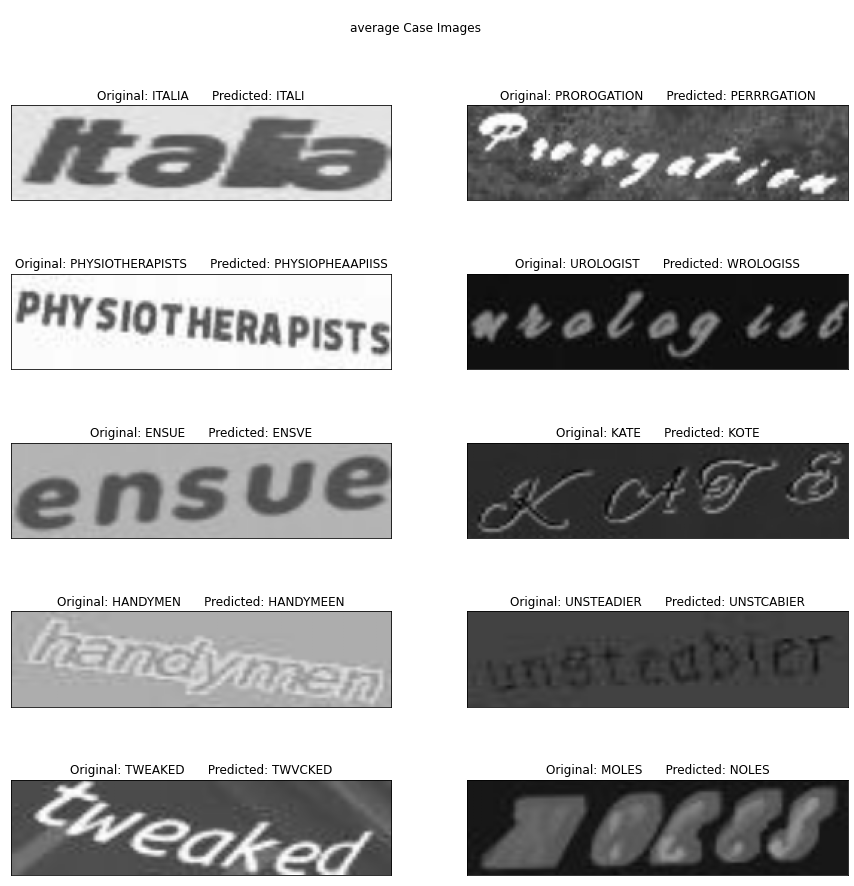

In [19]:
average_case_images = test_df[test_predictions['case']=='average']['path'].index.values
random.shuffle(average_case_images)
view_images(average_case_images, 'average Case')

### Images in the WORST CASE Set
<br>

In [20]:
test_predictions['case'] = ["worst" if p > 40 else test_predictions['case'][idx] for idx, p in enumerate(test_predictions['mismatch_percentage'].values)]

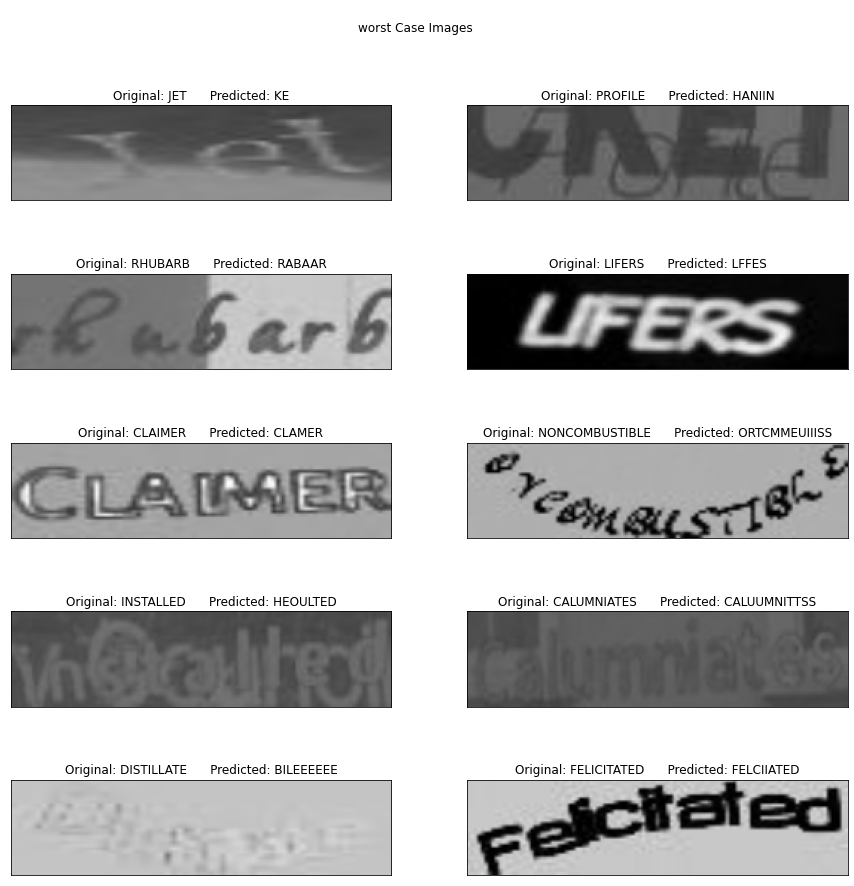

In [21]:
worst_case_images = test_df[test_predictions['case']=='worst']['path'].index.values
random.shuffle(worst_case_images)
view_images(worst_case_images, 'worst Case')

#### Distribution of Images based on the Case
<br>

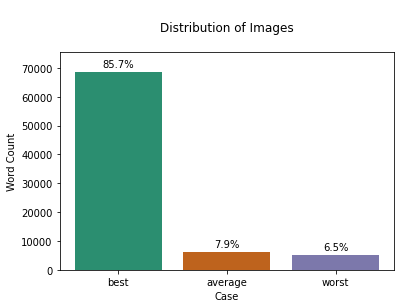

In [22]:
ax = sns.countplot(x='case', data=test_predictions, order=['best', 'average', 'worst'], palette='Dark2')
plt.title("\nDistribution of Images\n")
plt.xlabel("Case")
plt.ylabel("Word Count")
plt.margins(0.05, 0.1)

for p in ax.patches:
  x=p.get_bbox().get_points()[:,0]
  y=p.get_bbox().get_points()[1,1]
  ax.annotate('{:.1f}%'.format(100.*y/len(test_predictions)), (x.mean(), y+1000), 
          ha='center', va='bottom') 
plt.show()

<br><br>

### Obeservations :-
<br>

Following Inferences can be made from the above Sample Images,

1. Majority of the Images belonging to the Best Case Set have a clear differentiation between the Word and the Background, also the characters are easily distinguishable and their is not much visual overlap between the characters.


2. Majority of the Images belonging to the Average Case Set have distinguishable word and the background but the characters in the word either have some overlap or are very similar visually.


3. Majority of the Images belonging to the Worst Case Set have indistinguishable word and the background and there is significant overlap between the words or the words have a very different way of writing.
<br><br>

### Improvements :-
<br>

1. The issues persisting in the majority of Images in the Average Set Images and some of the Best Case Images can be removed by training the model with a more larger dataset and performing augmentation.


2. The issues persisting in the Images of the Worst Case Set can be reduced upto some extent by training the model on a large dataset and performing augmentation, but most of the issues will still persist and this is due the fact that the images belonging to this set are very bad visually and hence it is better to replace such images with more clean and visually good images.
<br><br>

### Ideal Image to be used for Prediction :-
<br>

Following are the characterstics of the image to have higher chances of correct prediction,

1. The Image should be visually clean.


2. There should be a decent amount of distiguishability between the word and the background.


3. The words should not have much overlap.


4. It is better to have simple representation of word in the image rather than having very styled cusrsive representations.

    __Some of the Examples are given below,__

<img src=https://i.ibb.co/m936hMX/sample1.png>
<img src=https://i.ibb.co/NL3pKn4/Screenshot-from-2021-07-15-00-51-29.png>
<img src=https://i.ibb.co/Y2kYhym/sample3.png>
<br><br>